In [1]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester, list_transformer
import xgboost as xgb
import math as math
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt


# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
out_dir = os.path.join(data_dir, 'results/XGBoost_w_Clinical_ACVD_v_Rest_Jie_only')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = np.logical_and(SampleMeta["Study Accession"].isin(['PRJEB21528']).to_numpy(), SampleMeta["BMI"].to_numpy() != -99)
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(274, 38)

In [7]:
SampleMeta.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'study',
       'Study No. (From VG sheet (V-*) from SB sheet (S-*))', 'Title of Paper',
       'Author (year)', 'Journal', 'Study Accession',
       'Sample Accession or Sample ID', 'Sample title (ENA/SRA)',
       'Sample title (Paper)', 'Subject Id (If available)', 'Age (Years)',
       'BMI', 'Gender', 'GRoP', 'Phenotype', 'FBG', 'TRIG', 'LDLC', 'CHOL',
       'HDLC', 'Phys_Ex', 'Smoking', 'Residence', 'milk', 'meat', 'alcohol',
       'Diet1', 'Diet2', 'medication', 'Sequencing Platform',
       'Library layout (SINGLE/PAIRED)', 'Read count after Quality control',
       'Healthy', 'age_group', 'age_category'],
      dtype='object')

In [8]:
SampleMeta['meat'].value_counts()

-99    274
Name: meat, dtype: int64

In [9]:
np.any(SampleMeta['Age (Years)'] == -99)

False

In [10]:
SampleMeta['milk'].value_counts()

-99    274
Name: milk, dtype: int64

In [11]:
SampleMeta['Gender'].value_counts()

M    160
F    114
Name: Gender, dtype: int64

In [12]:
np.sum(SampleMeta['BMI'] == -99)

0

In [13]:
SampleMeta["Phenotype"].value_counts()

ACVD           144
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

In [14]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(274, 903)

In [15]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [16]:
ClinicalContinuousMat = SampleMeta.loc[:, ['Age (Years)', 'BMI']].to_numpy().astype('float64')

In [17]:
ClinicalBinaryMat = (SampleMeta.loc[:, ['Gender']].to_numpy() == 'Male').astype('float64')
ClinicalBinaryMat.shape

(274, 1)

In [18]:
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [19]:
X = [MatrixData, ClinicalContinuousMat, ClinicalBinaryMat]

In [20]:
y = SampleMeta['Phenotype'].to_numpy().astype('str') == 'ACVD'
y = y.astype('int64')

In [21]:
pd.value_counts(SampleMeta['Phenotype'])

ACVD           144
Healthy         75
Overweight      40
Obesity          8
Underweight      7
Name: Phenotype, dtype: int64

# Define and Train Model

In [22]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

retrain = True
n_splits = 10
out_path = os.path.join(out_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(out_dir):
        os.system('rm -rf ' + out_dir)
    os.mkdir(out_dir)
    # transformer pipeline
    # make pipeline
    microbiome_pipeline = Pipeline([('scaler0', StandardScaler()), ('pca', PCA(n_components=5)), ('scaler1', StandardScaler())])
    clinical_continous_pipeline = StandardScaler()
    clinical_binary_pipeline = FunctionTransformer()
    pipeline_list = [microbiome_pipeline, clinical_continous_pipeline, clinical_binary_pipeline]
    pipeline_list_transformer = list_transformer(pipeline_list)

    # make classifier + trainer
    clf = xgb.XGBClassifier(objective="binary:logistic", 
                            eval_metric="logloss", 
                            gamma=5, subsample=0.5, 
                            max_delta_step=1, 
                            scale_pos_weight=math.sqrt(1721
    /328))
    param_grid = {'eta': [0.3],
                 'max_depth': [6]}
    model = model_selection.GridSearchCV(clf, param_grid, scoring = metrics.make_scorer(RECALL_SCORE), cv = 5)
    MyTrainer = Trainer(model = model, pipeline_X=pipeline_list_transformer)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE, test_frac=0.40)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train(X, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()
    


Running for split 1 of 10
Using predict_proba
getting predictions from probs
Running for split 2 of 10
Using predict_proba
getting predictions from probs
Running for split 3 of 10
Using predict_proba
getting predictions from probs
Running for split 4 of 10
Using predict_proba
getting predictions from probs
Running for split 5 of 10
Using predict_proba
getting predictions from probs
Running for split 6 of 10
Using predict_proba
getting predictions from probs
Running for split 7 of 10
Using predict_proba
getting predictions from probs
Running for split 8 of 10
Using predict_proba
getting predictions from probs
Running for split 9 of 10
Using predict_proba
getting predictions from probs
Running for split 10 of 10
Using predict_proba
getting predictions from probs


In [23]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.910853,train
1,0.886404,train
2,0.901681,train
3,0.881049,train
4,0.881948,train
5,0.897698,train
6,0.886523,train
7,0.894737,train
8,0.868764,train
9,0.884610,train


<AxesSubplot:xlabel='stage', ylabel='score'>

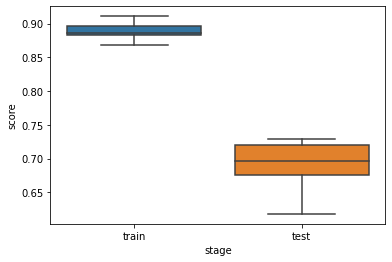

In [24]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

<AxesSubplot:xlabel='score_type', ylabel='value'>

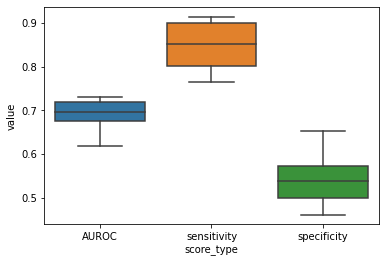

In [25]:
def AUROC_SCORE(y_true, y_pred):
    return metrics.roc_auc_score(y_true, y_pred, average='macro')
def SENSITIVITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=1)
def SPECIFICITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=0)

scorer_list = [AUROC_SCORE, SENSITIVITY_SCORE, SPECIFICITY_SCORE]
scorer_names = ['AUROC', 'sensitivity', 'specificity']
other_metrics = {'split': [], 'score_type': [], 'value': []}
for i in range(n_splits):
    test_idx = MyMultiTrainTester.test_idx[i]
    X_test = [x[test_idx, :] for x in X]
    y_test = y[test_idx]
    Trainer_i = MyMultiTrainTester.TrainerList[i]
    for j in range(len(scorer_list)):
        score_type = scorer_names[j]
        score_func = scorer_list[j]
        other_metrics['split'].append(i)
        other_metrics['score_type'].append(score_type)
        other_metrics['value'].append(Trainer_i.score(X_test, y_test, score_func))
    
other_metrics_df = pd.DataFrame(other_metrics)
sns.boxplot(data = other_metrics_df, x = 'score_type', y = 'value')

In [26]:
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.8510015408320493

In [27]:
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.5382907880133185

In [28]:
other_metrics_df.to_csv(os.path.join(out_dir, 'misc_score_metrics.csv'))

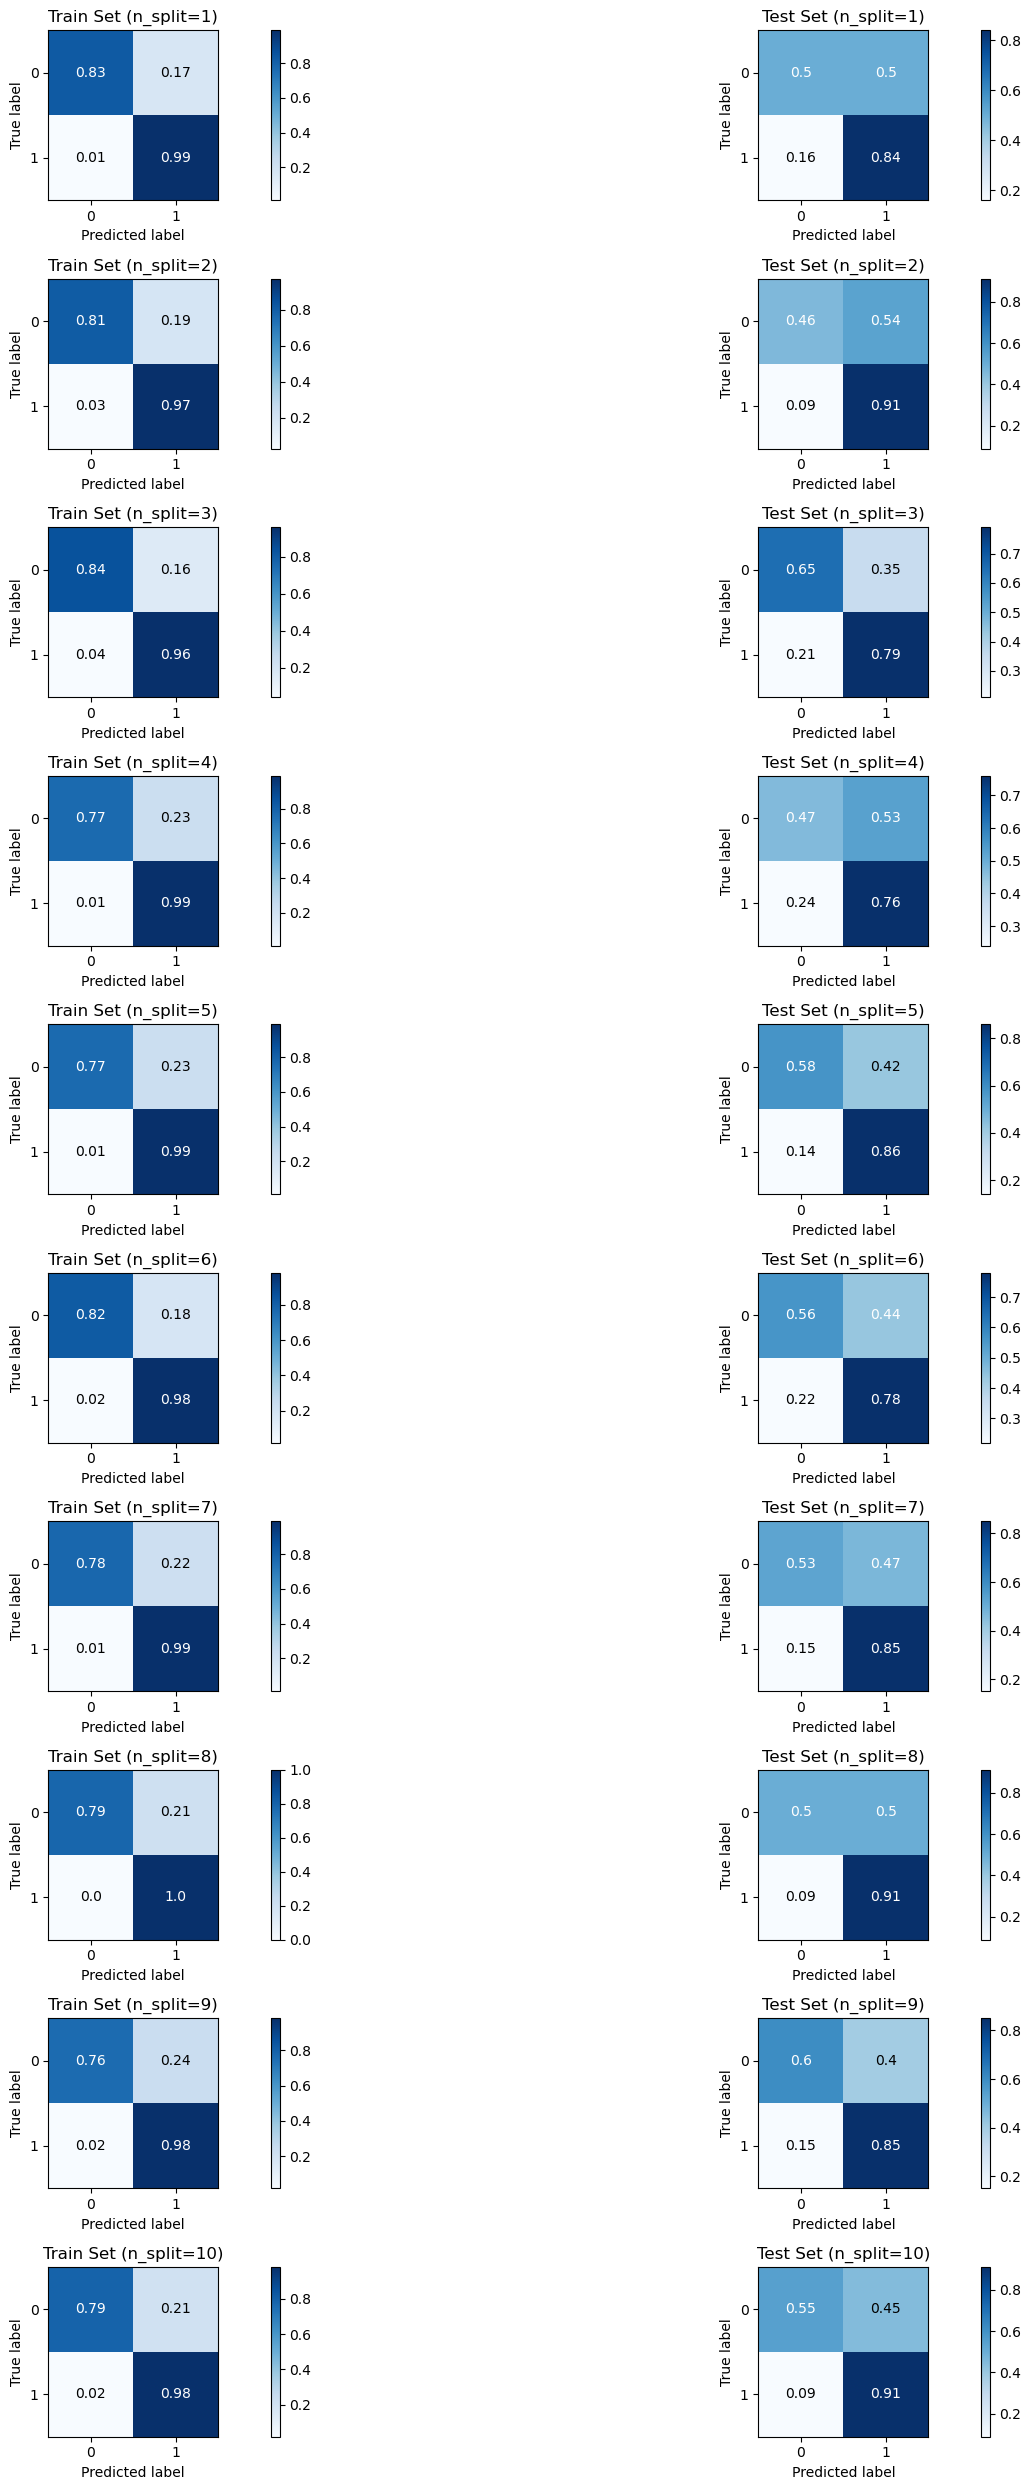

In [29]:
MyMultiTrainTester.plot_confusion(normalize=True)

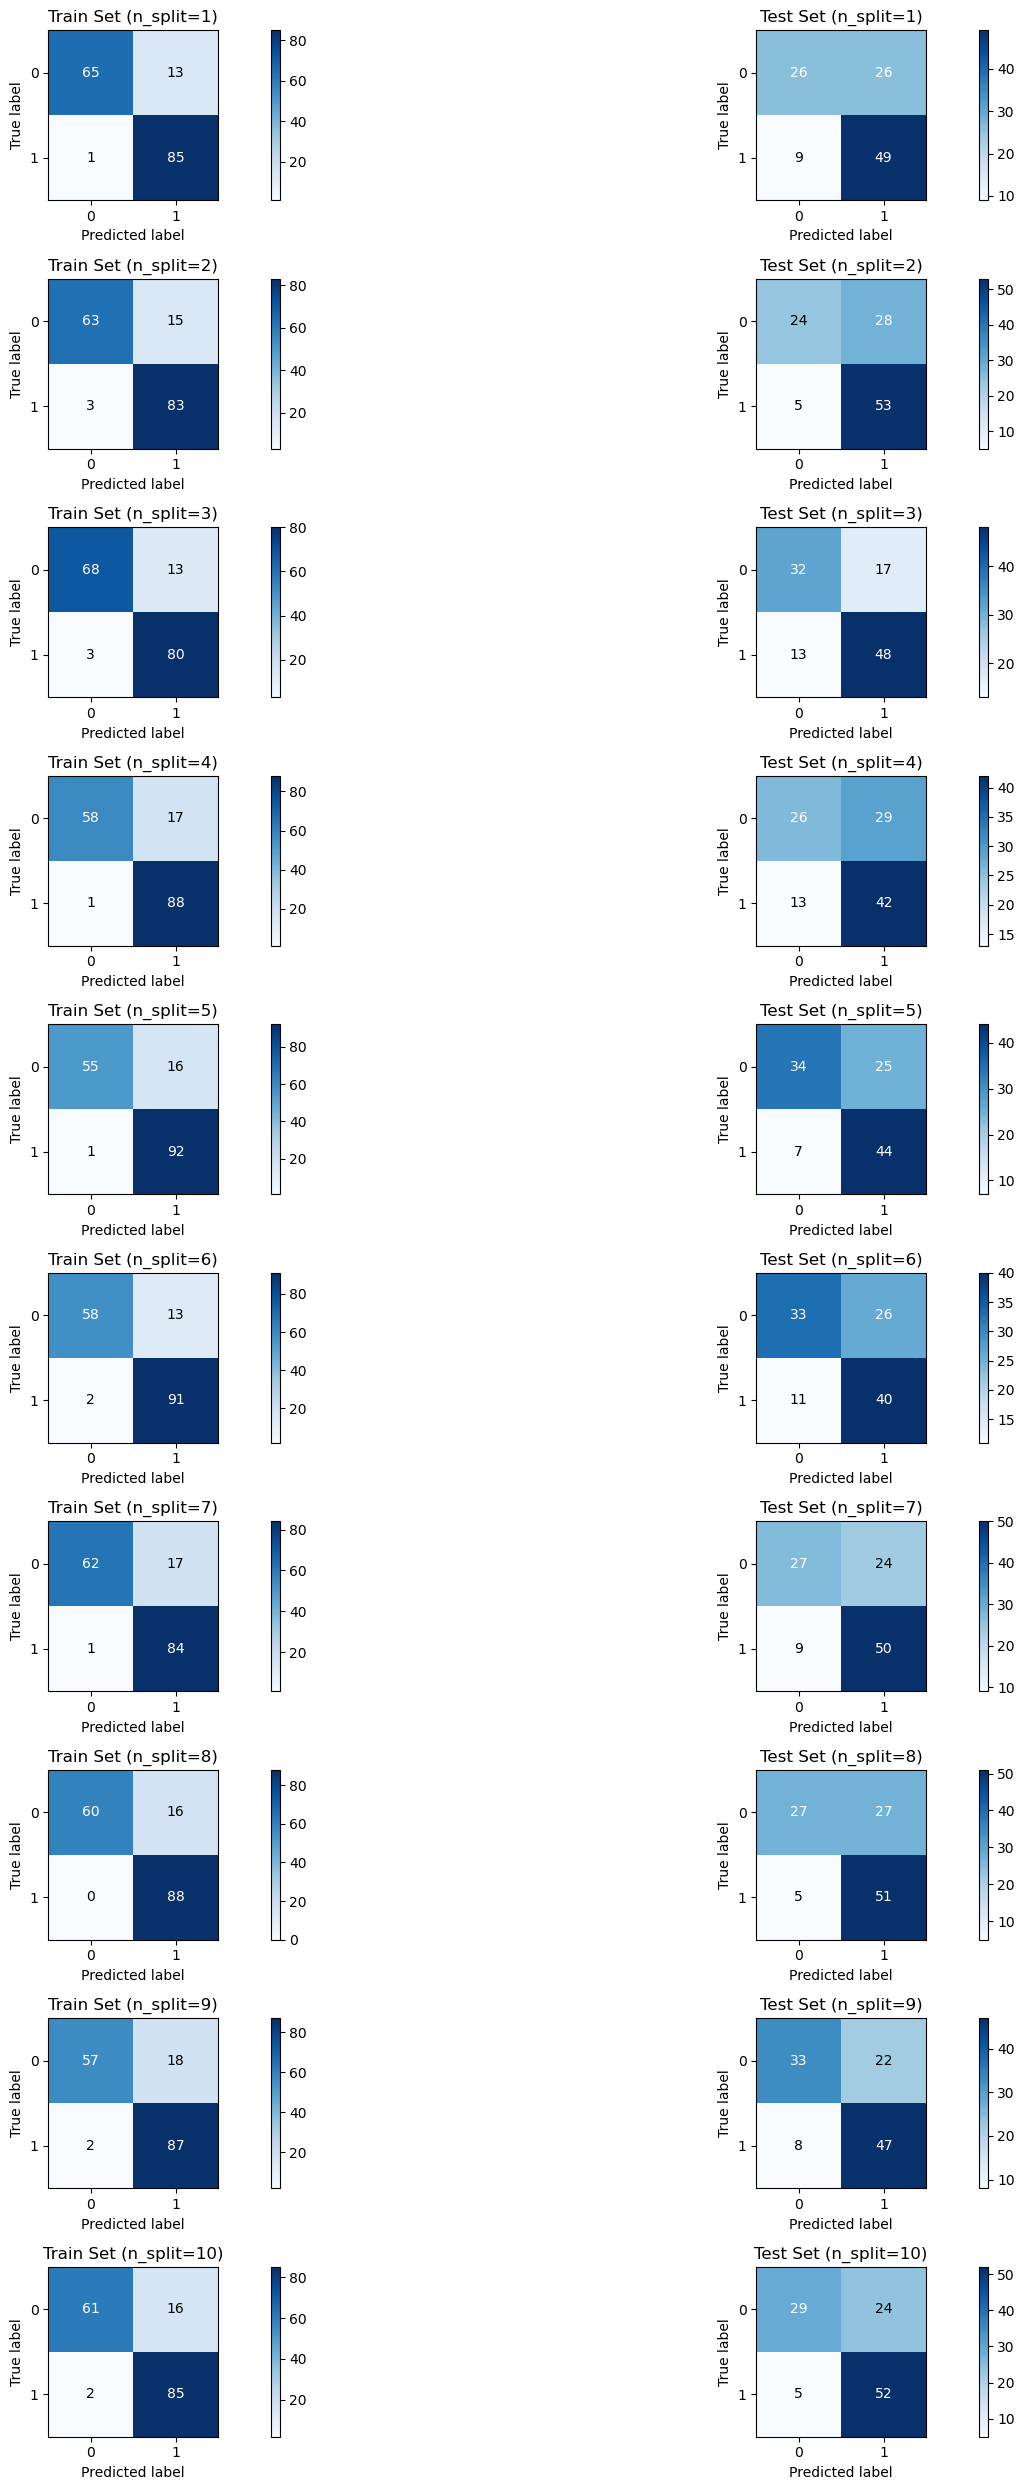

In [30]:
MyMultiTrainTester.plot_confusion(normalize=False)

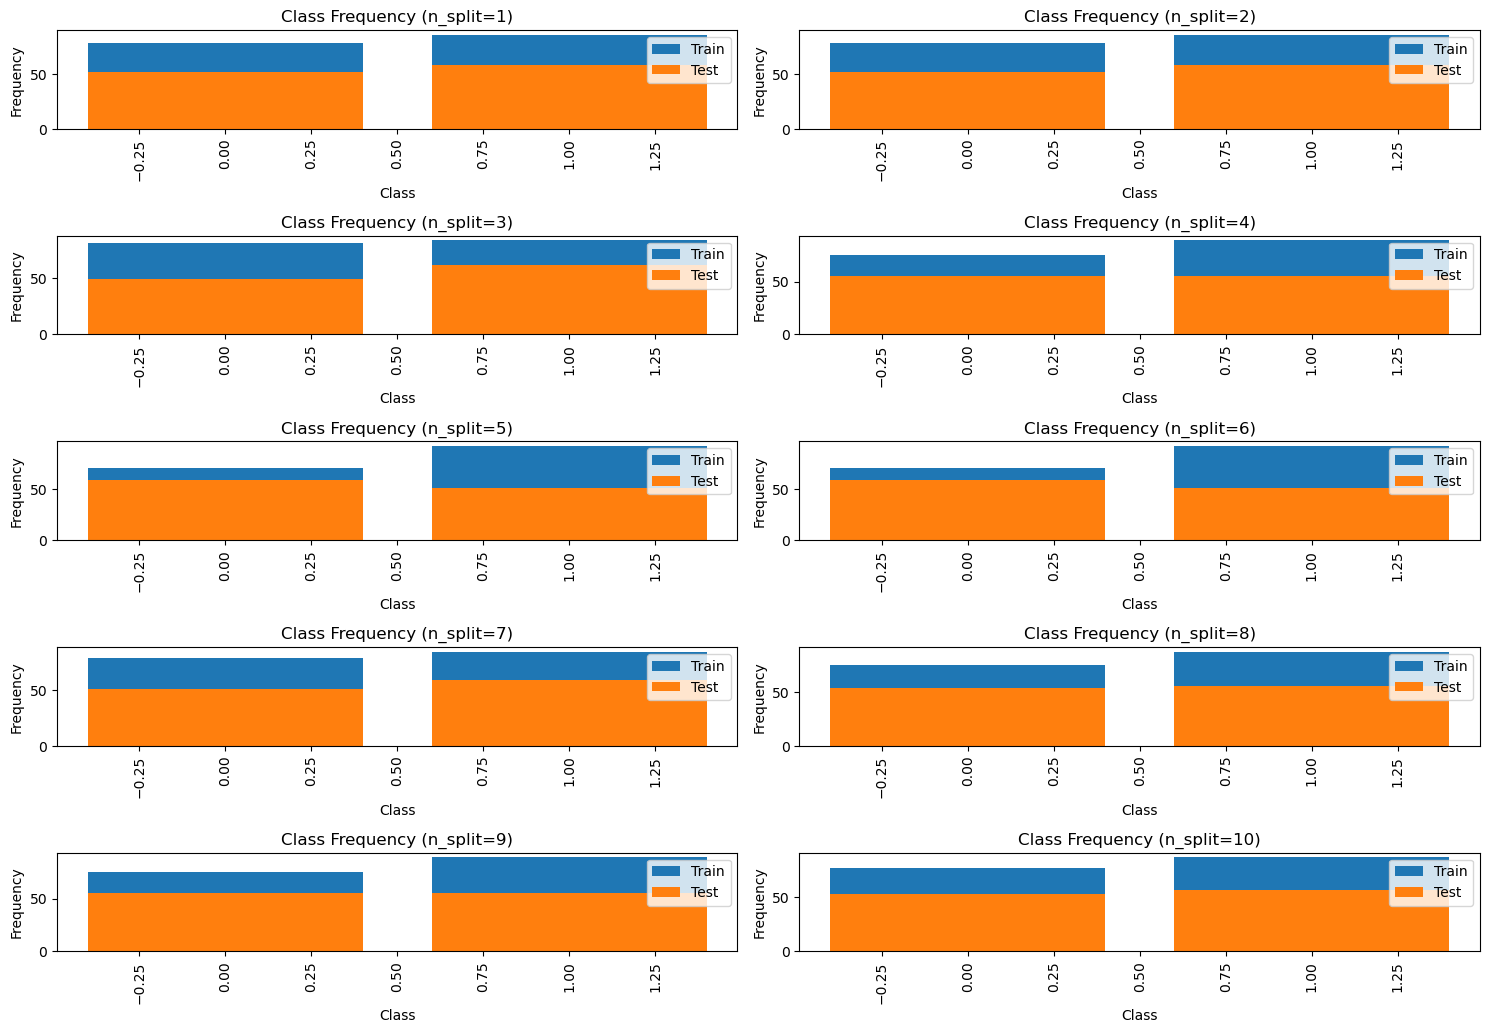

In [31]:
MyMultiTrainTester.plot_class_freq(normalize=True)

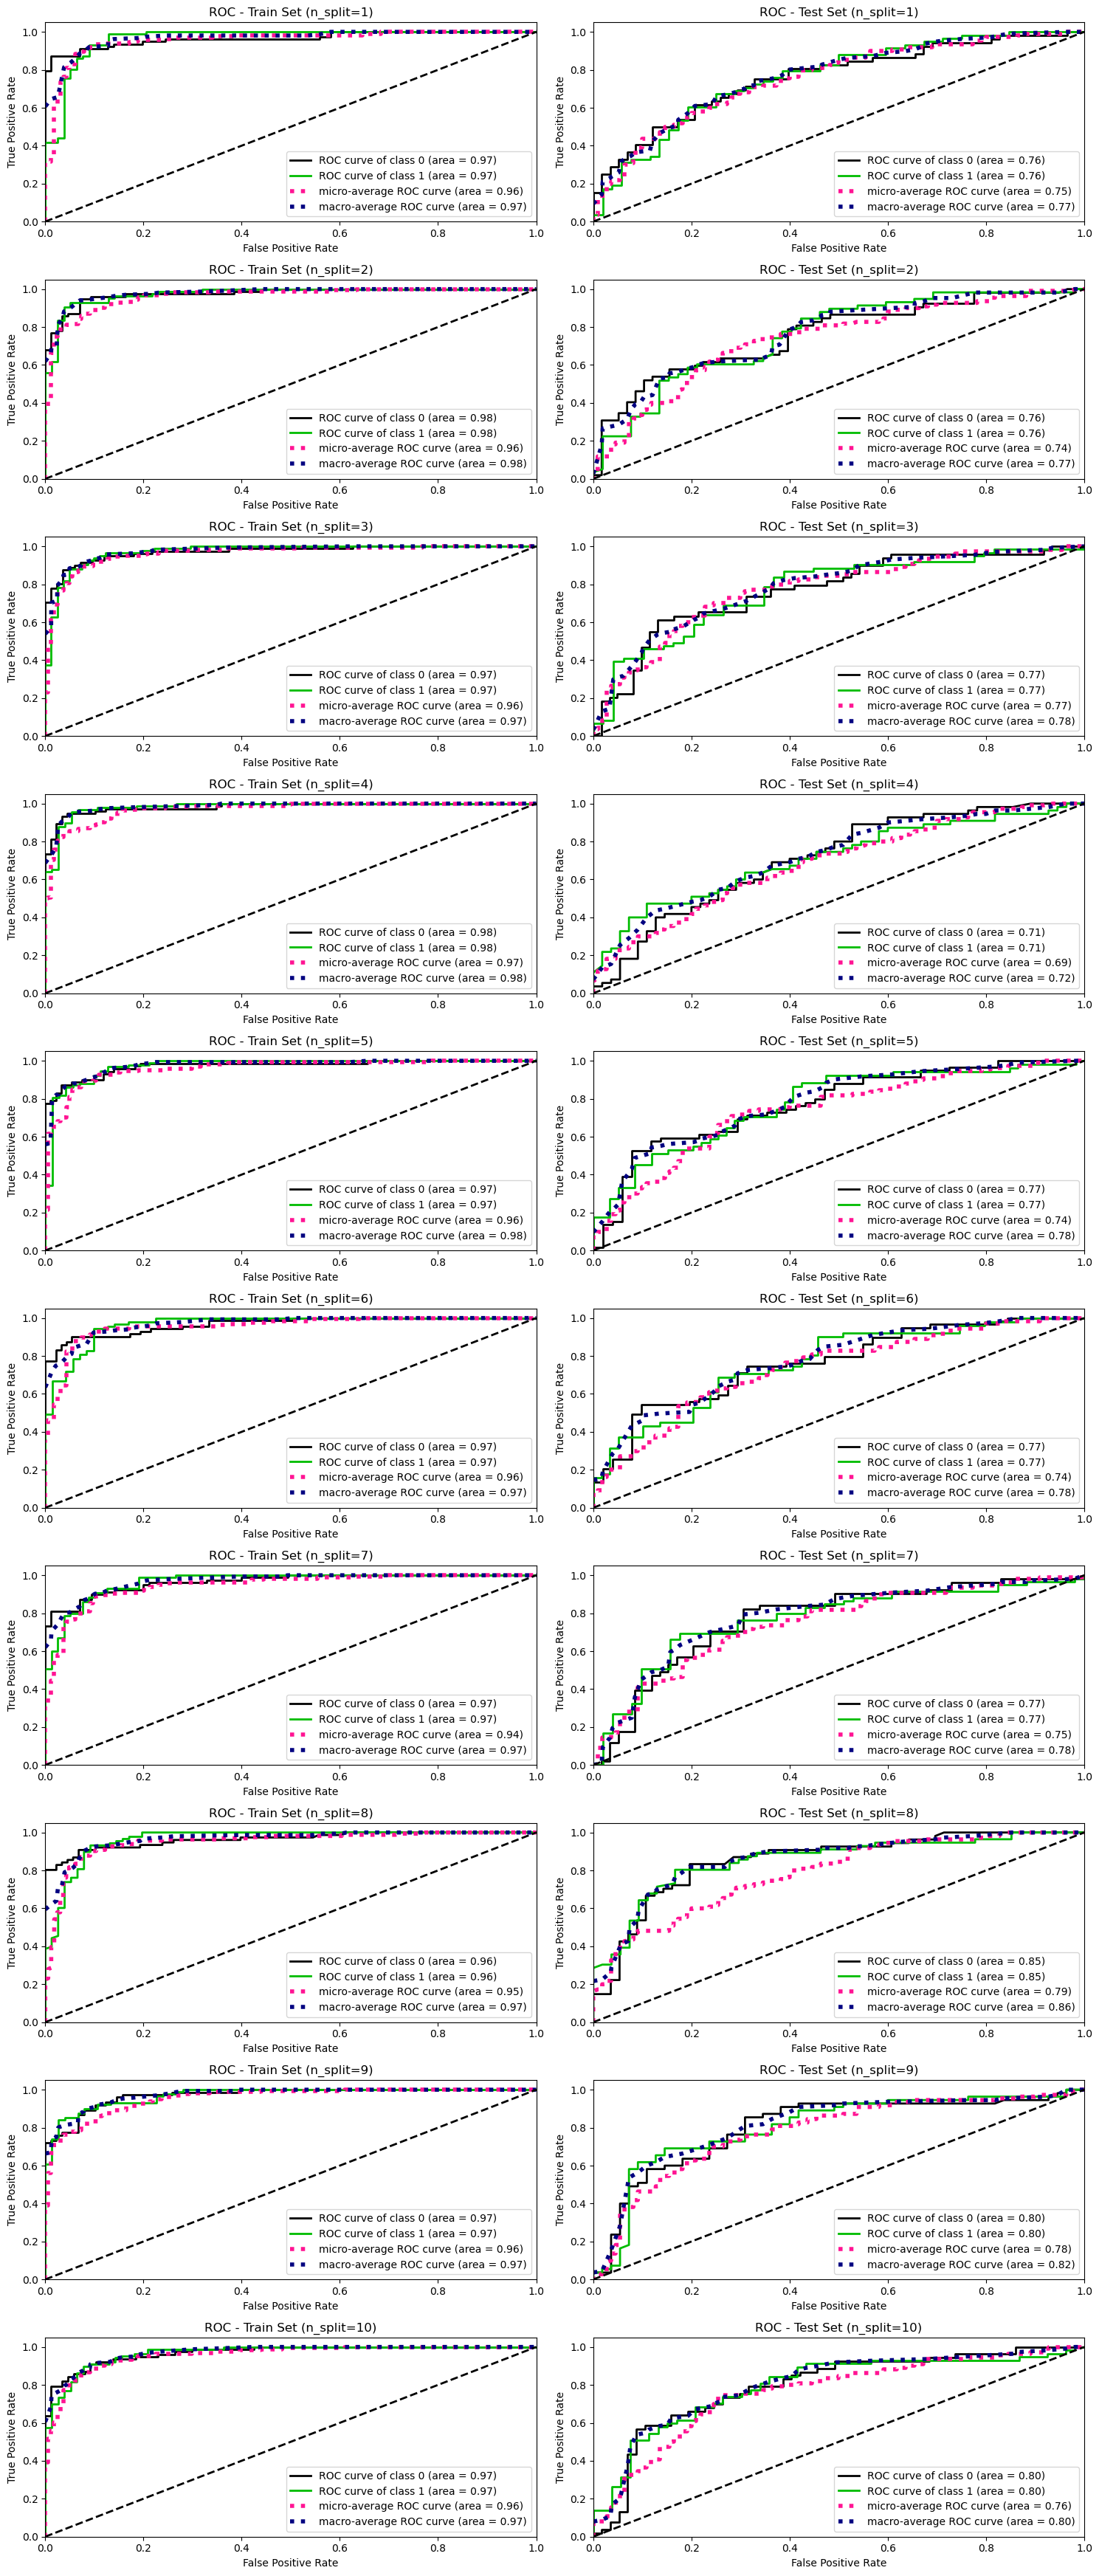

In [32]:
MyMultiTrainTester.plot_roc(figsize=(15,35))

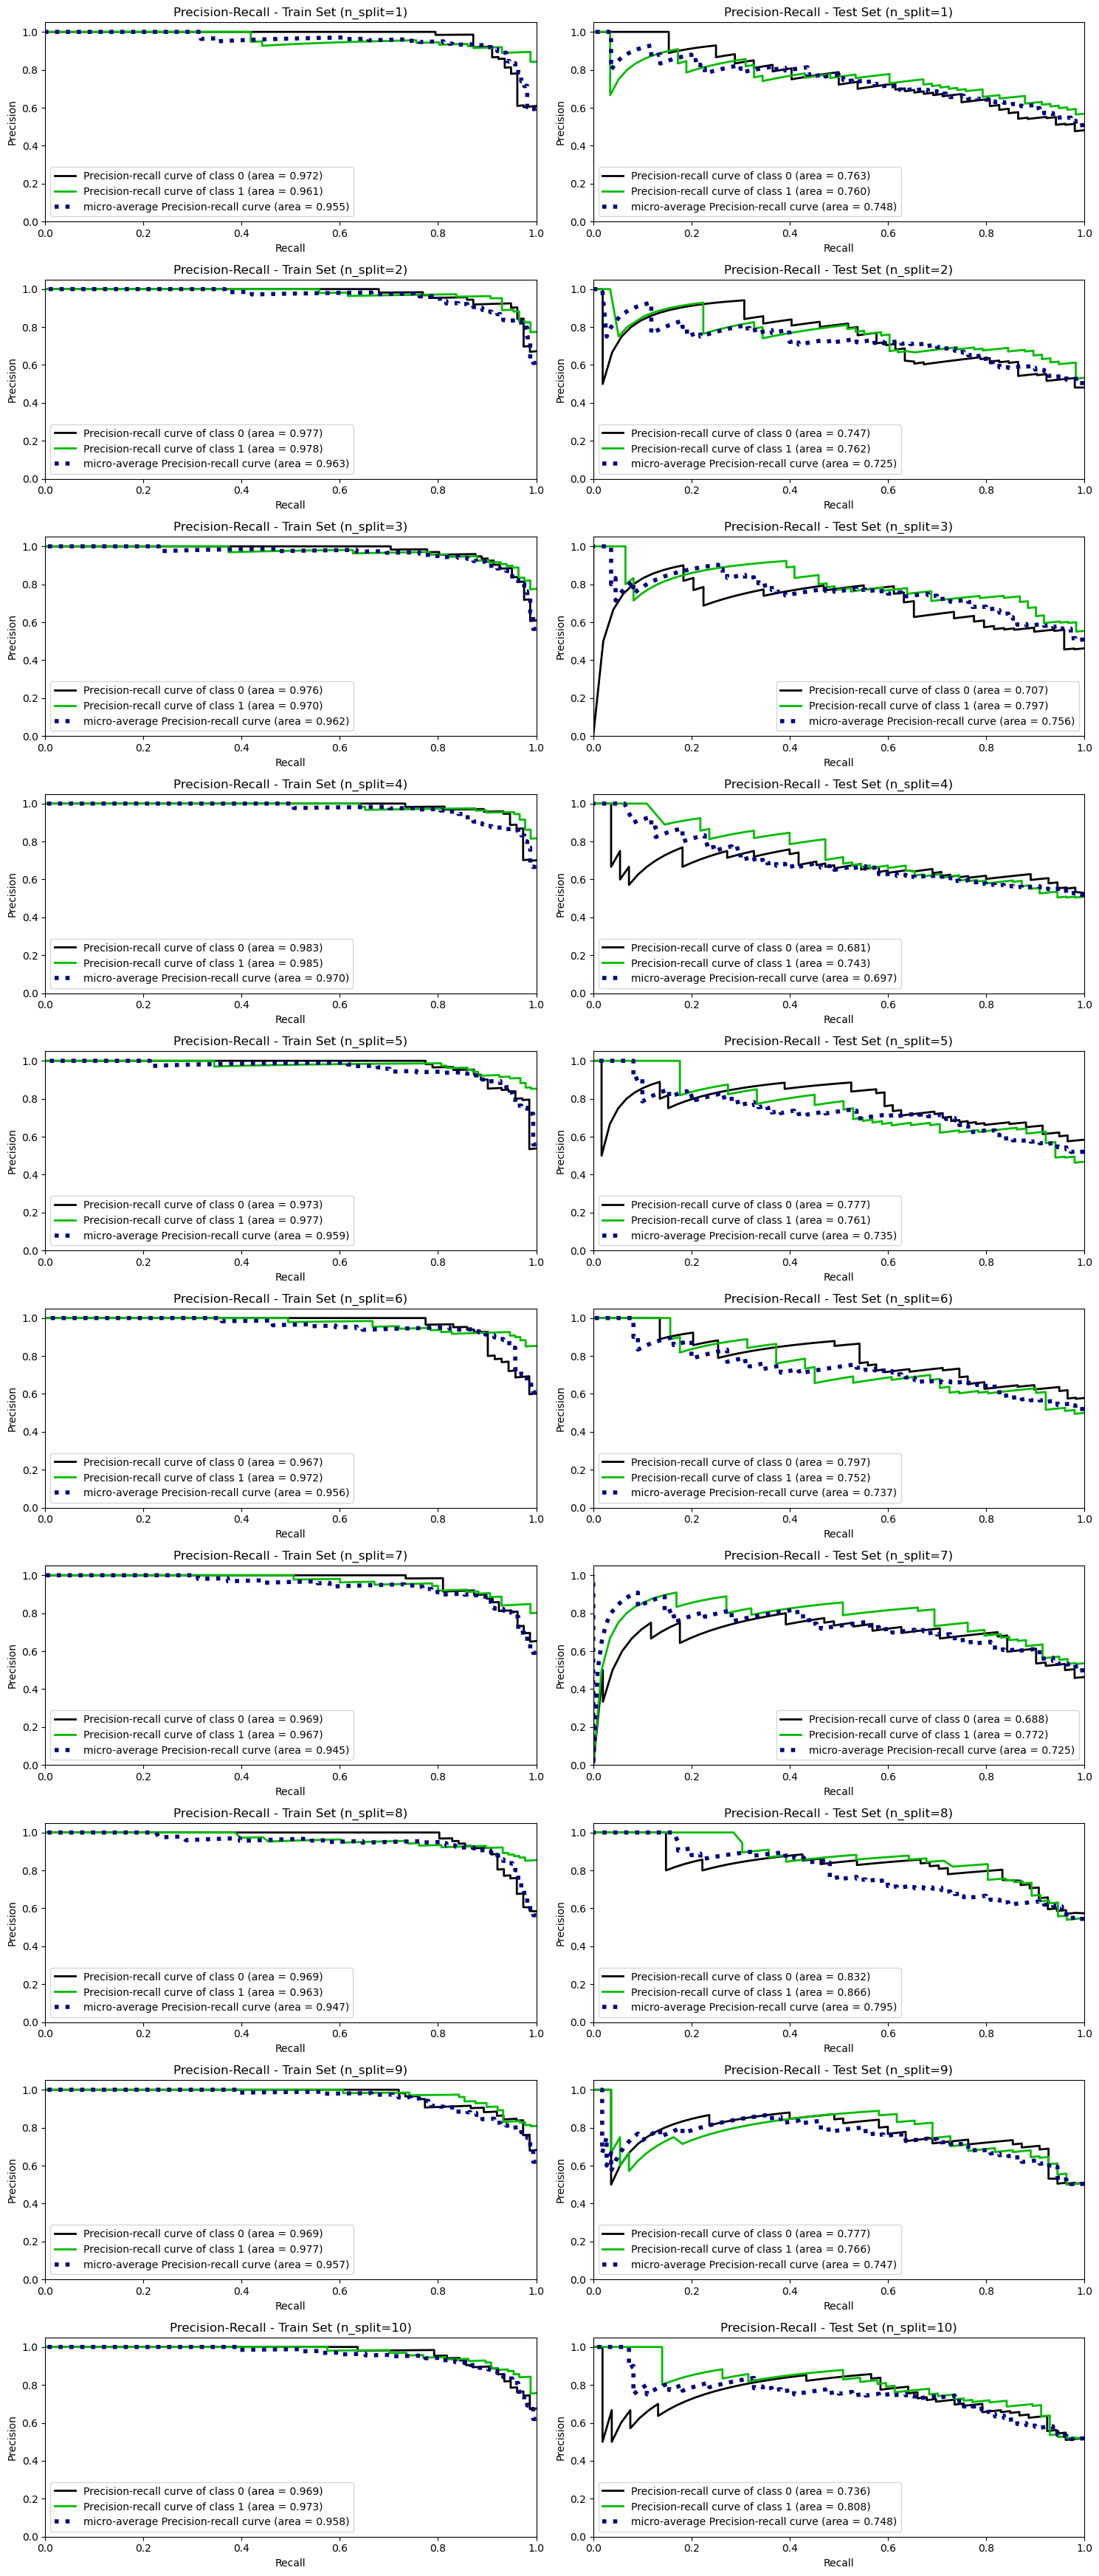

In [33]:
MyMultiTrainTester.plot_precrecall(figsize=(15,35))